In [ ]:
# Only needed when running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install scikit-learn

In [ ]:
# Imports and environment checks
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import pathlib



# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from PIL import Image
# from google.colab import files

In [ ]:
# Dataset configuration - EDIT this if your dataset root differs.
# The notebook will try common locations based on your provided structure.
CANDIDATE_ROOTS = [
    '/content/drive/MyDrive/dataset/new',
    '/mnt/data/dataset/new',
    '/mnt/data/dataset',
    'dataset/new',
    'dataset'
]

DATA_ROOT = None
for p in CANDIDATE_ROOTS:
    if os.path.isdir(p):
        DATA_ROOT = p
        break

if DATA_ROOT is None:
    raise FileNotFoundError('Could not find dataset root. Edit CANDIDATE_ROOTS or set DATA_ROOT manually.')

print('Using DATA_ROOT =', DATA_ROOT)

# Expected class folder names (adjust if needed)
CLASS_NAMES = ['brain_menin', 'brain_glioma']
# Clean class display names
DISPLAY_NAMES = {'brain_menin':'meningioma','brain_glioma':'glioma'}

# Paths we'll try to use
train_dir = os.path.join(DATA_ROOT, 'train')
val_dir = os.path.join(DATA_ROOT, 'val')
test_dir = os.path.join(DATA_ROOT, 'test')

print('train_dir exists?', os.path.isdir(train_dir))
print('val_dir exists?', os.path.isdir(val_dir))
print('test_dir exists?', os.path.isdir(test_dir))

# If val is missing we'll use validation_split in image_dataset_from_directory
USE_SPLIT = not os.path.isdir(val_dir)
print('Will use validation_split?', USE_SPLIT)

Using DATA_ROOT = /content/drive/MyDrive/dataset/new
train_dir exists? True
val_dir exists? False
test_dir exists? True
Will use validation_split? True


In [ ]:
# Dataset parameters
IMG_SIZE = (224,224)
BATCH_SIZE = 16
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

if os.path.isdir(train_dir):
    print('Loading from train/ (with or without separate val)')
    if USE_SPLIT:
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=IMG_SIZE,
            shuffle=True,
            seed=SEED,
            validation_split=0.2,
            subset='training'
        )
        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=IMG_SIZE,
            shuffle=True,
            seed=SEED,
            validation_split=0.2,
            subset='validation'
        )
    else:
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir,
            labels='inferred',
            label_mode='int',
            batch_size=BATCH_SIZE,
            image_size=IMG_SIZE,
            shuffle=True,
            seed=SEED,
        )
        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            val_dir,
            labels='inferred',
            label_mode='int',
            batch_size=BATCH_SIZE,
            image_size=IMG_SIZE,
            shuffle=False,
            seed=SEED,
        )
else:
    # If train/ not present, try using DATA_ROOT directly and split
    dataset_dir = DATA_ROOT
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        label_mode='int',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=0.2,
        subset='training'
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        label_mode='int',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=0.2,
        subset='validation'
    )

# Test dataset (if available)
if os.path.isdir(test_dir):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False
    )
else:
    test_ds = None

# Inspect class names inferred by directory order
inferred_class_names = train_ds.class_names
print('Inferred class names:', inferred_class_names)

# Map to display names if your folders are brain_menin / brain_glioma
mapped_names = [DISPLAY_NAMES.get(n, n) for n in inferred_class_names]
print('Mapped class names (display):', mapped_names)

# Prefetch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
if test_ds is not None:
    test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Loading from train/ (with or without separate val)
Found 837 files belonging to 2 classes.
Using 670 files for training.
Found 837 files belonging to 2 classes.
Using 167 files for validation.
Found 210 files belonging to 2 classes.
Inferred class names: ['brain_glioma', 'brain_menin']
Mapped class names (display): ['glioma', 'meningioma']


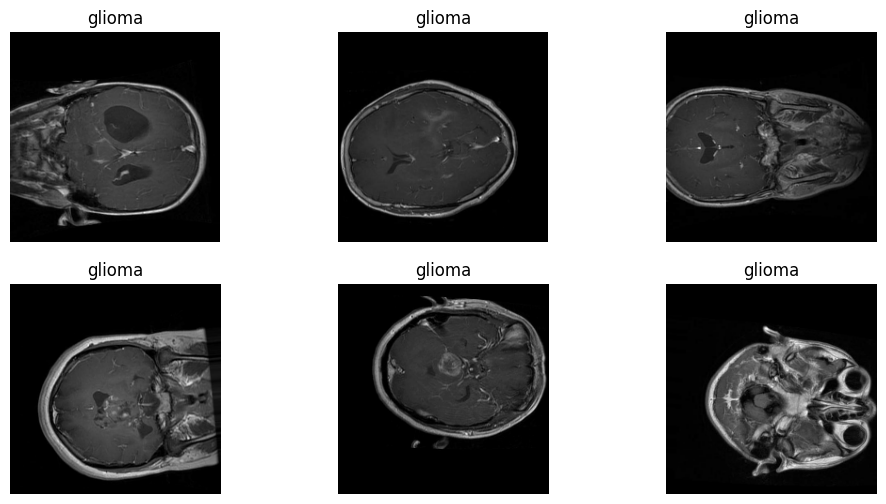

In [ ]:
# Data augmentation + preprocessing layer
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Visualize a batch
import matplotlib.pyplot as plt
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12,6))
    for i in range(min(6, images.shape[0])):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(mapped_names[labels[i].numpy()])
        plt.axis('off')
    break


In [ ]:
# Build the ResNet50 model (transfer learning)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # freeze

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(inferred_class_names), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │      4,098 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Callbacks
checkpoint_path = '/mnt/data/resnet_meningioma_glioma.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

EPOCHS = 12
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5013 - loss: 1.0127

42/42 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.5064 - loss: 1.0033 - val_accuracy: 0.9701 - val_loss: 0.1340
Epoch 2/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.9267 - loss: 0.2430 - val_accuracy: 0.9701 - val_loss: 0.1161
Epoch 3/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.9303 - loss: 0.2686 - val_accuracy: 0.9701 - val_loss: 0.1102
Epoch 4/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.9547 - loss: 0.1803 - val_accuracy: 0.9701 - val_loss: 0.1044
Epoch 5/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.9465 - loss: 0.1845 - val_accuracy: 0.9701 - val_loss: 0.0981
Epoch 6/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9454 - loss: 0.1766

42/42 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.9455 - loss: 0.1765 - val_accuracy: 0.9760 - val_loss: 0.0929
Epoch 7/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.9463 - loss: 0.2077 - val_accuracy: 0.9760 - val_loss: 0.0881
Epoch 8/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.9375 - loss: 0.1753 - val_accuracy: 0.9760 - val_loss: 0.0844
Epoch 9/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.9511 - loss: 0.2012 - val_accuracy: 0.9760 - val_loss: 0.0812
Epoch 10/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.9549 - loss: 0.1581 - val_accuracy: 0.9760 - val_loss: 0.0784
Epoch 11/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.9517 - loss: 0.1530 - val_accuracy: 0.9760 - val_loss: 0.0769
Epoch 12/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.9602 - loss: 0.1543 - val_accuracy: 0.9760 - val_loss: 0.0742


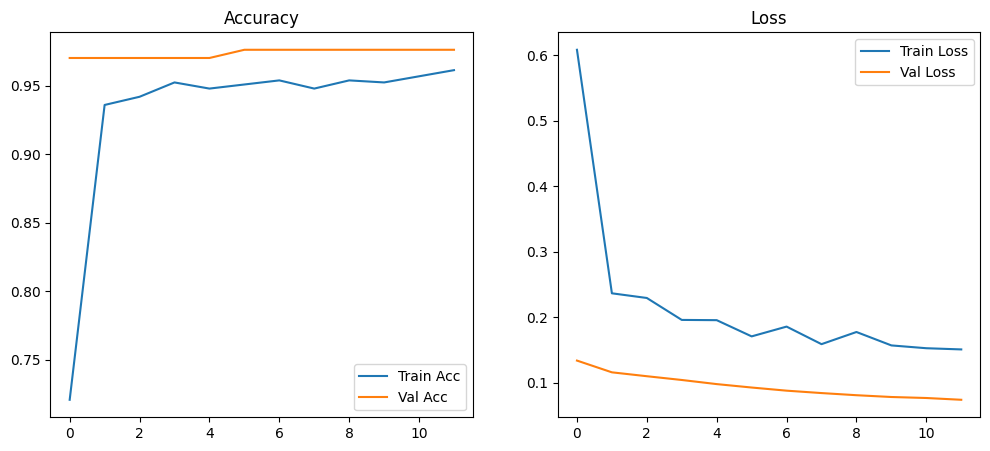

In [ ]:
# Plot training curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


Evaluating on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9772 - loss: 0.0642
Test loss, Test acc: [0.12035863846540451, 0.9476190209388733]
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.99      0.97       200
  meningioma       0.00      0.00      0.00        10

    accuracy                           0.95       210
   macro avg       0.48      0.50      0.49       210
weighted avg       0.91      0.95      0.93       210



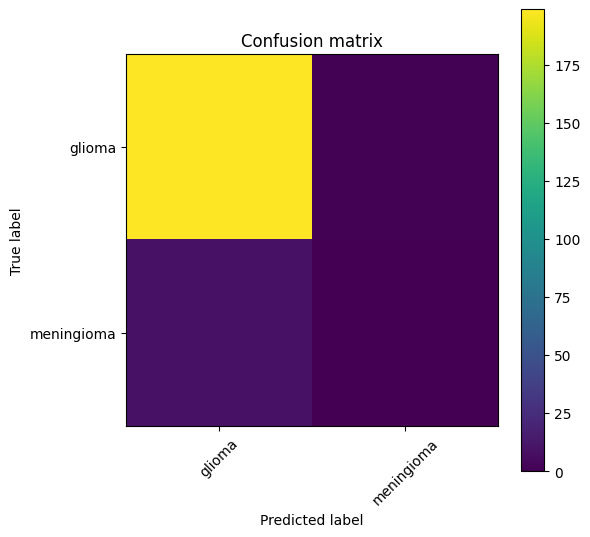

In [ ]:
# Evaluate on test set if available
if test_ds is not None:
    print('Evaluating on test set...')
    results = model.evaluate(test_ds)
    print('Test loss, Test acc:', results)

    # Get predictions and true labels
    y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
    y_pred_prob = model.predict(test_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=mapped_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(mapped_names))
    plt.xticks(tick_marks, mapped_names, rotation=45)
    plt.yticks(tick_marks, mapped_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
else:
    print('No test dataset found at', test_dir)


In [ ]:
# Save final model (already saved via checkpoint). To load:
# from tensorflow.keras.models import load_model
# model = load_model('/mnt/data/resnet_meningioma_glioma.h5')

# Example: predict on a single image
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_names=mapped_names):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    idx = np.argmax(preds, axis=1)[0]
    return class_names[idx], preds[0][idx]

# Example usage (edit path):
predict_image('/content/brain_glioma_0007.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


('glioma', np.float32(0.9540116))

Please upload an image file for prediction:


Saving brain_glioma_0068.jpg to brain_glioma_0068.jpg
Uploaded file: brain_glioma_0068.jpg


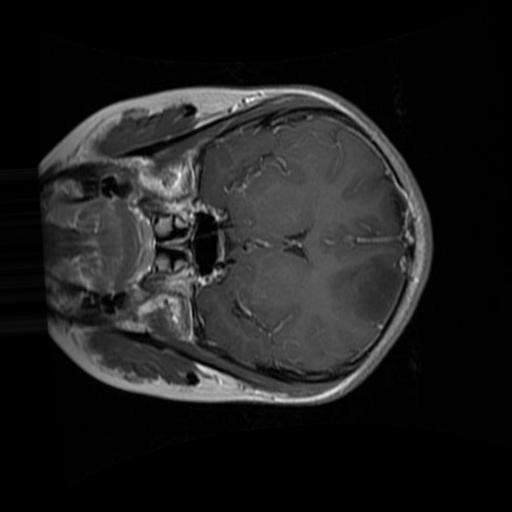

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step

Predicted class: glioma with confidence: 0.99


In [ ]:
from google.colab import files
from IPython.display import Image, display

print('Please upload an image file for prediction:')
uploaded = files.upload()

for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    img_path = filename
    break # Assuming only one image will be uploaded for prediction

if 'img_path' in locals():
    display(Image(filename=img_path, width=200))
    predicted_class, confidence = predict_image(img_path, model)
    print(f'\nPredicted class: {predicted_class} with confidence: {confidence:.2f}')
else:
    print('No image was uploaded.')